In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import scipy as sp
import re
import os
from itertools import groupby
import datetime as dt

#visualizing results
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('poster', rc={'font.size':35,
                              'axes.titlesize':50,
                              'axes.labelsize':35})

pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 50000)
pd.set_option('display.width', 100000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

### Program name

AS_DRL_OPTOTTL

### Variable Definitions

- E   = event identity stamp
- T   = event time stamp

### Event Stamps

#### Trial bits
- 29  = Traylight turns off #trial end
- 100 = End of session marker

#### within bits
- 1   = Rt Lever response during DRL
- 2   = Lt Lever response during DRL
- 5   = Reinforcement delivery
- 7   = Head entry during DRL
- 15  = Feeder tray head entry following reward
- 37  = DRL reset, respond too early

#### remainder
- 3   = Rt Lever response during ITI
- 4   = Lt Lever response during ITI
- 16  = ITI over
- 24  = Head entry during ITI
- 28  = Traylight turns on
- 33  = ITI starts
- 34  = House light turns on
- 35  = House light turns off
- 36  = DRL time up, waiting for response to get reward
- 38  = Manual pellet delivery
- 39  = Extend right Lever
- 40  = Extend left Lever
- 41  = Retract right lever
- 42  = Retract left lever
- 43  = Right lever cue light on
- 44  = Right lever cue light off
- 45  = Left lever cue light on
- 46  = Left lever cue light off
- 50  = Optostim triggered


### Functions

In [2]:
def get_file_info(file_path_name):
    # takes in a file path, finds the date, animal_number, session, session number, and sub_session, saves each accordingly
    import re
    
    task = file_path_name.split('/')[-1].split('_')[0]
    session = float(file_path_name.split('/')[-1].split('_')[1])
    animal = int(file_path_name.split('/')[-1].split('_')[2])
    date = file_path_name.split('/')[-1].split('_')[3]

    return task, session, animal, date

In [3]:
def make_array_from_path(file_path_name):
    # takes in file path, creates array (each row of array is a row from original med file)
    import numpy as np
    import pandas as pd
    
    data = pd.read_table(file_path_name)
    data_table = pd.DataFrame(data = data)
    data_array = data_table.values
    
    return data_array

In [4]:
def get_events_and_times(array, event_letter, time_letter):
    #takes in array and the letters Med PC program uses to signify an event_stamp and time_stamp; 
    #finds all event_stamps and corresponding time_stamps; creats pandas dataframe
    import re
    import numpy as np
    import pandas as pd

    i = 0
    event_data = []
    time_data = []
    while i < len(array):
        
        if re.search(event_letter, str(array[i])):
            i = i + 1
            while re.search('\[\'\ \ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    event_data.append(float(element))
                i = i + 1
            
        if re.search(time_letter, str(array[i])):
            i = i + 1
            while re.search('\[\'\ \ ', str(array[i])):
                split = array[i][0].split()[1:]
                for element in split:
                    time_data.append(float(element))
                if i<len(array)-1:
                    i = i + 1
                else:
                    break 
        else:
            i = i + 1
    
    eandt = np.column_stack((event_data, time_data))
    es_et = pd.DataFrame(data = eandt)
    es_et.columns = ['event_stamp', 'time_stamp']
    
    return es_et

In [5]:
def get_trial_times_DRL(events_and_times, trial_end, session_end):
    #takes in dataframe of events and corresponding time_stamps and the Med PC program code for pellet deliveries and end of trial segment
    #finds time_stamps for each start and end, puts into new dataframe

    session_start = np.array(events_and_times.iloc[[0]]['time_stamp'].values)
    session_end = list(events_and_times[events_and_times['event_stamp'] == session_end]['time_stamp'].values)
    trial_end_times = list(events_and_times[events_and_times['event_stamp'] == trial_end]['time_stamp'].values)
    
    start_times = np.append(session_start, trial_end_times)
    end_times = np.append(trial_end_times, session_end)

    times = pd.DataFrame(data = [start_times, end_times])
    times = times.T
    times.columns = ['trial_start', 'trial_end']
    
    return times

In [6]:
def create_trial_df(events_and_times, trial_times):
    #takes in df of events and times and df of trial times
    #creates tidy df containing events and times according to trials
    i = 0
    trial_data = pd.DataFrame()
    
    while i < len(trial_times):
        data = events_and_times[(events_and_times['time_stamp'] >= trial_times['trial_start'][i]) & (events_and_times['time_stamp'] <= trial_times['trial_end'][i] - .01)]
        data['trial_#'] = [i]*len(data)
        data['trial_start'] = trial_times['trial_start'][i]
        data['trial_end'] = trial_times['trial_end'][i]
        trial_data = pd.concat([trial_data, data], axis = 0, ignore_index=True)
        i = i + 1
    
    return trial_data

In [7]:
def count(trial_data, event_num):
    #get count of event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    count = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        count.append(len(data[data['event_stamp'] == event_num]))
        i = i + 1
    
    return count

In [8]:
def latency(trial_data, event_num):
    #get latency of time between trial_start and event_num
    trials = len((trial_data['trial_#'].unique()))
    i = 0
    latency_1st = []
    latency_IRT = []
    while i < trials:
        data = trial_data[trial_data['trial_#'] == i]
        data = data[data['event_stamp'] == event_num]
        if len(data) < 1:
            latency_1st.append(np.nan)
            latency_IRT.append(np.nan)
        else:
            latency_1st.append((data['time_stamp'] - data['trial_start']).values[0]/100)
            latency_IRT.append(data['time_stamp'].diff().mean()/100)
        i = i + 1
    
    return latency_1st, latency_IRT

In [9]:
def create_session_df(trial_data, event_dic):
    
    trials = len((trial_data['trial_#'].unique()))
    
    #get times
    times_df = pd.DataFrame(data = [trial_data.groupby('trial_#')['trial_start'].unique(), trial_data.groupby('trial_#')['trial_end'].unique()])
    times_df = times_df.T  
        
    i = 0
    trial_times = []

    while i < times_df.shape[0]:
        trial_time = (times_df.iloc[i]['trial_end'] - times_df.iloc[i]['trial_start'])/100
        trial_times.append(trial_time[0])
        i += 1
    
    session_data = pd.DataFrame(index=np.arange(0,trials))

    for name, event in event_dic.items():
        session_data[str(name + '_count')] = count(trial_data, event)
        session_data[str(name + '_latency_1st')], session_data[str(name + '_latency_IRT')] = latency(trial_data, event)
    
    session_data['trial_num'] = np.arange(session_data.shape[0])
    session_data['trial_duration'] = trial_times
    
    return session_data

### Read in meta data

In [10]:
#read animal info (lever assignment, group etc) into df

path_animal_info = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/assignments/round12_meta.xlsx'
    
animal_info = pd.read_excel(path_animal_info)
animal_info = pd.DataFrame(data = animal_info)

print(animal_info.shape)
animal_info.head()

(48, 4)


,animal,cage,group,lever
0,1215,SA319,4,right
1,1216,SA319,4,right
2,1217,SA319,4,right
3,1236,SA326,5,right
4,1237,SA326,5,right


### Read in task data

In [11]:
path = '/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL'

file_names = os.listdir(path)
print(len(file_names))

file_paths = []

for file in file_names:
    
    file_path = path + '/' + file
    file_paths.append(file_path)

print(len(file_paths))
file_paths[0]

186
186


'/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL5_3_1116_210115'

### Get trial data

In [25]:
%%time
final_trial_data = pd.DataFrame()

bit_dic = {'right_lever': 1, 'left_lever': 2, 'reinforcement': 5, 'HE_DRL': 7, 'HE_reward': 15, 'DRL_reset': 37}

for file in file_paths:

    print(file) 
    
    if file.split('/')[-1] == '.DS_Store':
        continue
        
    #proccess file
    task, session, animal, date = get_file_info(file)
    array = make_array_from_path(file)
    events_and_times = get_events_and_times(array, "E:", "T:")
    trial_times = get_trial_times_DRL(events_and_times, 29, 100)
    trial_data = create_trial_df(events_and_times, trial_times)
    session_data = create_session_df(trial_data, bit_dic)
   
    #get animal metadata
    active_lever = animal_info[animal_info['animal'] == int(animal)]['lever'].iloc[0]
    group = int(animal_info[animal_info['animal'] == int(animal)]['group'])
    cage = animal_info[animal_info['animal'] == int(animal)]['cage'].iloc[0]
    
    #create pandas tidy df for within session
    session_data['task'] = [task]*(session_data.shape[0])
    session_data['date'] = [date]*(session_data.shape[0])
    session_data['animal'] = [animal]*(session_data.shape[0])
    session_data['session'] = [session]*(session_data.shape[0])
    session_data['active_lever'] = [active_lever]*(session_data.shape[0])
    session_data['group'] = [group]*(session_data.shape[0])
    session_data['cage'] = [cage]*(session_data.shape[0])
   
    session_data = session_data[['task', 'date', 'session', 'cage', 'animal', 'group', 'active_lever', 
                                 'trial_num', 'trial_duration',
                                 'reinforcement_count', 'reinforcement_latency_1st',
                                 'HE_DRL_count', 'HE_DRL_latency_1st', 'HE_DRL_latency_IRT', 
                                 'HE_reward_count', 'HE_reward_latency_1st',
                                 'right_lever_count', 'right_lever_latency_1st', 'right_lever_latency_IRT', 
                                 'left_lever_count', 'left_lever_latency_1st', 'left_lever_latency_IRT',
                                 'DRL_reset_count', 'DRL_reset_latency_1st', 'DRL_reset_latency_IRT']]
    
    #add to final data frame
    final_trial_data = pd.concat([final_trial_data, session_data], axis = 0, ignore_index=True)

print(final_trial_data.shape)
final_trial_data.head()

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL5_3_1116_210115
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL15_1_1124_210118
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL5_2_1118_210116
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL15_3_1123_210120
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL15_1_1136_210118
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL15_2_1120_210119
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL15_1_1128_210118
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL15_3_1118_210122
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL30

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL5_1_1238_210416
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL30_3_1144_210123
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL5_2_1135_210115
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL5_2_1222_210419
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL5_2_1144_210115
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL30_3_1135_210123
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL30_2_1136_210122
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL5_3_1129_210116
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL30_3_

/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL30_3_1136_210123
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL5_1_1237_210416
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL5_2_1124_210115
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL5_1_1120_210114
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL30_3_1124_210123
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL5_2_1128_210115
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL5_1_1143_210113
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL5_1_1116_200113
/Users/abbieschindler/Documents/Schindler_Lab/Data/Behavior/med_boxes/PCA_PD_DRL/round12/DRL/DRL5_2_12

,task,date,session,cage,animal,group,active_lever,trial_num,trial_duration,reinforcement_count,reinforcement_latency_1st,HE_DRL_count,HE_DRL_latency_1st,HE_DRL_latency_IRT,HE_reward_count,HE_reward_latency_1st,right_lever_count,right_lever_latency_1st,right_lever_latency_IRT,left_lever_count,left_lever_latency_1st,left_lever_latency_IRT,DRL_reset_count,DRL_reset_latency_1st,DRL_reset_latency_IRT
0,DRL5,210115,3.0,279,1116,4,right,0,1384.39,1,1384.38,39,31.03,32.679474,0,NaN,1,1384.37,NaN,0,NaN,NaN,0,NaN,NaN
1,DRL5,210115,3.0,279,1116,4,right,1,1060.62,1,1060.61,48,132.66,16.264468,1,3.21,1,1060.60,NaN,0,NaN,NaN,0,NaN,NaN
2,DRL5,210115,3.0,279,1116,4,right,2,254.99,0,NaN,30,97.27,5.241034,1,3.06,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
3,DRL15,210118,1.0,281,1124,4,left,0,48.70,1,48.69,7,1.82,1.998333,0,NaN,0,NaN,NaN,6,0.82,9.572,5,0.82,3.83
4,DRL15,210118,1.0,281,1124,4,left,1,43.35,1,43.34,2,1.47,5.550000,1,0.89,0,NaN,NaN,1,43.33,NaN,0,NaN,NaN


In [26]:
#calculate percent erro
final_trial_data['DRL_error'] = final_trial_data['DRL_reset_count'] / (final_trial_data['DRL_reset_count'] + final_trial_data['reinforcement_count'])

#get single column for lever params (based on active_lever)

def lever_convert(a, b, c):
    if a == 'right':
        x = b
    if a == 'left':
        x = c
        
    return x

final_trial_data['LP_count'] = final_trial_data.apply(lambda row : lever_convert(row['active_lever'], 
                                                                     row['right_lever_count'], 
                                                                     row['left_lever_count']), axis = 1)

final_trial_data['LP_latency_1st'] = final_trial_data.apply(lambda row : lever_convert(row['active_lever'], 
                                                                     row['right_lever_latency_1st'], 
                                                                     row['left_lever_latency_1st']), axis = 1)

final_trial_data['LP_latency_IRT'] = final_trial_data.apply(lambda row : lever_convert(row['active_lever'], 
                                                                     row['right_lever_latency_IRT'], 
                                                                     row['left_lever_latency_IRT']), axis = 1)

final_trial_data = final_trial_data[['task', 'date', 'session', 'cage', 'animal', 'group', 'active_lever', 
                         'trial_num', 'trial_duration', 'DRL_error',
                         'reinforcement_count', 'reinforcement_latency_1st', 
                         'DRL_reset_count', 'DRL_reset_latency_1st', 'DRL_reset_latency_IRT',
                         'HE_DRL_count', 'HE_DRL_latency_1st', 'HE_DRL_latency_IRT', 
                         'HE_reward_count', 'HE_reward_latency_1st', 
                         'LP_count', 'LP_latency_1st', 'LP_latency_IRT']]

### Get session data

In [27]:
sum_params = ['reinforcement_count', 'DRL_reset_count', 'LP_count', 'HE_DRL_count', 'HE_reward_count']
final_data_sum = final_trial_data.groupby(['task', 'date', 'session', 'cage', 'animal', 'group', 'active_lever'])[sum_params].sum().reset_index()

mean_params = ['DRL_error', 'trial_duration', 'reinforcement_latency_1st', 
               'DRL_reset_latency_1st', 'DRL_reset_latency_IRT',
               'HE_DRL_latency_1st', 'HE_DRL_latency_IRT', 
               'HE_reward_latency_1st',
               'LP_latency_1st', 'LP_latency_IRT']
final_data_mean = final_trial_data.groupby(['task', 'date', 'session', 'cage', 'animal', 'group', 'active_lever'])[mean_params].mean().reset_index()

final_session_data = final_data_sum.merge(final_data_mean, on=['task', 'date', 'session', 'cage', 'animal', 'group', 'active_lever'])
print(final_session_data.shape)
final_session_data.head()

(185, 22)


,task,date,session,cage,animal,group,active_lever,reinforcement_count,DRL_reset_count,LP_count,HE_DRL_count,HE_reward_count,DRL_error,trial_duration,reinforcement_latency_1st,DRL_reset_latency_1st,DRL_reset_latency_IRT,HE_DRL_latency_1st,HE_DRL_latency_IRT,HE_reward_latency_1st,LP_latency_1st,LP_latency_IRT
0,DRL15,210116,1.0,279,1116,4,right,23,89,112,116,23,0.228707,112.500000,116.913913,4.827143,2.734408,36.806250,14.397037,4.127391,96.956522,12.726406
1,DRL15,210116,1.0,281,1122,4,right,17,1068,1085,729,17,0.916309,150.000000,143.100000,2.548889,2.151745,7.974667,3.829832,2.232941,2.548889,4.984310
2,DRL15,210116,1.0,288,1143,5,left,12,959,971,691,12,0.952749,207.692308,208.959167,5.519231,2.578563,6.333077,3.707861,1.834167,5.519231,3.821331
3,DRL15,210116,1.0,288,1145,5,left,41,504,545,803,41,0.534660,64.285714,65.707561,6.598000,3.975242,6.060000,4.298144,1.110244,12.761463,6.848907
4,DRL15,210118,1.0,279,1117,4,right,40,331,371,452,40,0.694084,65.853659,66.279750,12.144706,4.156010,8.291579,5.940215,0.719750,13.195366,10.453761


In [28]:
final_session_data.columns.values
final_session_data_tidy = final_session_data.drop(['date', 'cage'], axis=1)
final_session_data_tidy_mean = final_session_data_tidy.groupby(['task', 'group', 'animal', 'active_lever']).mean().reset_index()

final_session_data_tidy_melt = final_session_data_tidy.set_index(['task', 'group', 'animal', 'active_lever', 'session']).unstack(-1).reset_index()
final_session_data_tidy_mean_melt = final_session_data_tidy_mean.set_index(['group', 'animal', 'active_lever', 'task', ]).unstack(-1).reset_index()

In [29]:
final_trial_data.to_csv('DRL_trial.csv', index=False)
final_session_data.to_csv('DRL_session.csv', index=False)
final_session_data_tidy_melt.to_csv('DRL_melt.csv', index=False)
final_session_data_tidy_mean_melt.to_csv('DRL_mean_melt.csv', index=False)

### Viz

In [36]:
final_session_data.head(1)

,task,date,session,cage,animal,group,active_lever,reinforcement_count,DRL_reset_count,LP_count,HE_DRL_count,HE_reward_count,DRL_error,trial_duration,reinforcement_latency_1st,DRL_reset_latency_1st,DRL_reset_latency_IRT,HE_DRL_latency_1st,HE_DRL_latency_IRT,HE_reward_latency_1st,LP_latency_1st,LP_latency_IRT
0,DRL15,210116,1.0,279,1116,4,right,23,89,112,116,23,0.228707,112.5,116.913913,4.827143,2.734408,36.80625,14.397037,4.127391,96.956522,12.726406


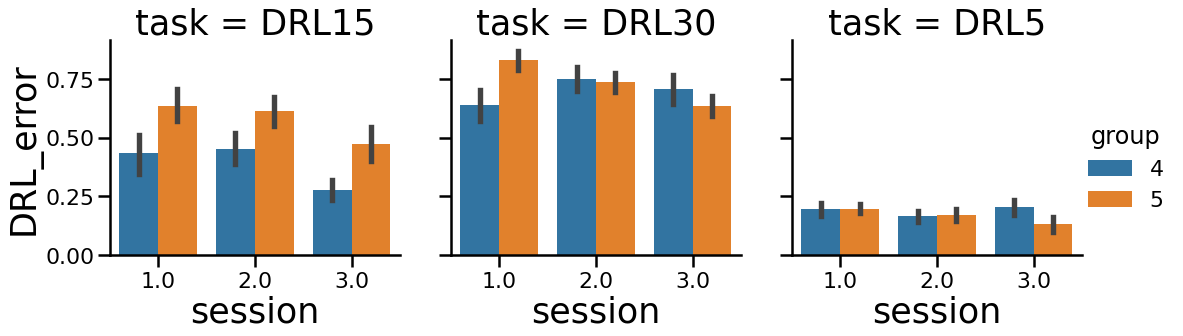

In [41]:
exclude_no_100 = [1116]
final_session_data_exclude = final_session_data[~final_session_data['animal'].isin(exclude_no_100)]

sns.catplot(x='session', y='DRL_error', data=final_session_data_exclude, hue='group', kind='bar', ci=68, col='task')
plt.show()

### Single for refactor

In [ ]:
file_path = file_paths[50]
print('file_path:', '\n', file_path, '\n')

task, session, animal, date = get_file_info(file_path)
print('task:', task, 'date:', date, 'animal:', animal, 'session:', session, '\n')

array = make_array_from_path(file_path)
print(array[0:5], '\n')

events_and_times = get_events_and_times(array, 'E:', 'T:')
print(events_and_times.head(), '\n')

trial_times = get_trial_times_DRL(events_and_times, 29, 100)
print(trial_times.head(), '\n')

trial_data = create_trial_df(events_and_times, trial_times)
print(trial_data.head(), '\n')

bit_dic = {'right_lever': 1, 'left_lever': 2, 'reinforcement': 5, 'HE_DRL': 7, 'HE_reward': 15, 'DRL_reset': 37}
session_data = create_session_df(trial_data, bit_dic)
session_data.columns.values